In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from scipy.stats import ttest_ind
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

2024-04-15 00:32:37.053662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 00:32:37.053768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 00:32:37.216316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define directories for train, test, and validation sets
train_dir = '/kaggle/input/pneumonia/Dl/train'
test_dir = '/kaggle/input/pneumonia/Dl/test'
validation_dir = '/kaggle/input/pneumonia/Dl/val'

# Define parameters for image preprocessing and augmentation
batch_size = 32
target_size = (224, 224)  # Change according to your image size requirements

# Create ImageDataGenerator for train set with augmentation
train_augmentation_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create ImageDataGenerator for test and validation sets (only normalization)
test_validation_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
# Flow images from directories with augmentation and preprocessing
train_augmentation_generator = train_augmentation_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'  # Change to 'categorical' if you have multiple classes
)

test_generator = test_validation_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


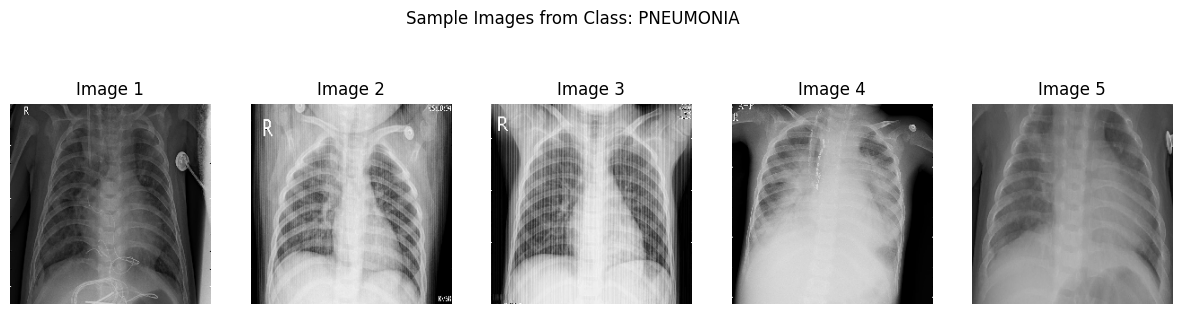

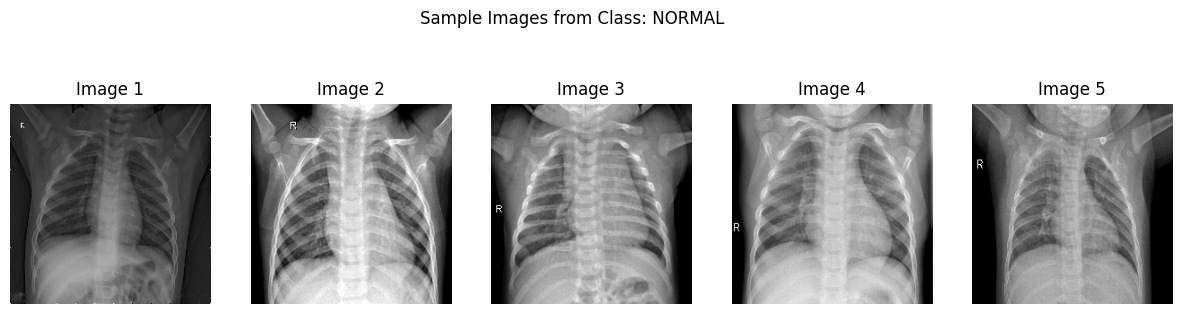

In [4]:
def plot_sample_images(directory, num_images=5):
    class_dirs = [os.path.join(directory, cls) for cls in os.listdir(directory)]
    
    # Plot sample images from each class directory
    for cls_dir in class_dirs:
        class_name = os.path.basename(cls_dir)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 4))
        fig.suptitle(f'Sample Images from Class: {class_name}')
        
        # Load and plot sample images
        image_files = [os.path.join(cls_dir, file) for file in os.listdir(cls_dir)[:num_images]]
        for i, image_file in enumerate(image_files):
            image = load_img(image_file, target_size=(224, 224))  # Load and resize image
            axes[i].imshow(image)
            axes[i].set_title(f'Image {i+1}')
            axes[i].axis('off')
        plt.show()
plot_sample_images(train_dir)

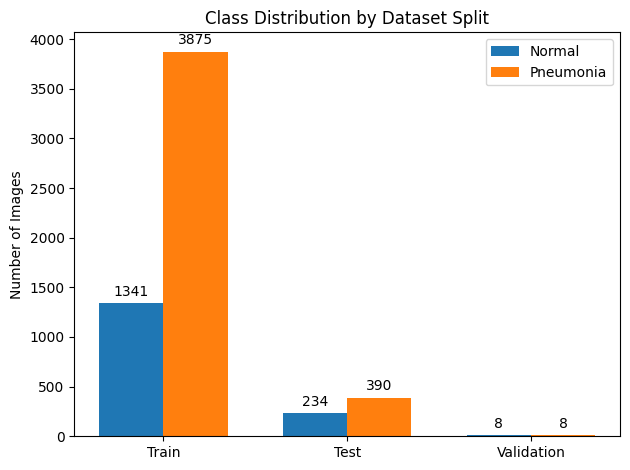

In [5]:
def count_images_in_classes(directory):
    num_normal = len(os.listdir(os.path.join(directory, 'NORMAL')))
    num_pneumonia = len(os.listdir(os.path.join(directory, 'PNEUMONIA')))
    return num_normal, num_pneumonia

# Count images in train, test, and validation sets
train_normal, train_pneumonia = count_images_in_classes(train_dir)
test_normal, test_pneumonia = count_images_in_classes(test_dir)
validation_normal, validation_pneumonia = count_images_in_classes(validation_dir)

# Create bar plot for class distribution
labels = ['Train', 'Test', 'Validation']
normal_counts = [train_normal, test_normal, validation_normal]
pneumonia_counts = [train_pneumonia, test_pneumonia, validation_pneumonia]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, normal_counts, width, label='Normal')
rects2 = ax.bar(x + width/2, pneumonia_counts, width, label='Pneumonia')

ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution by Dataset Split')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

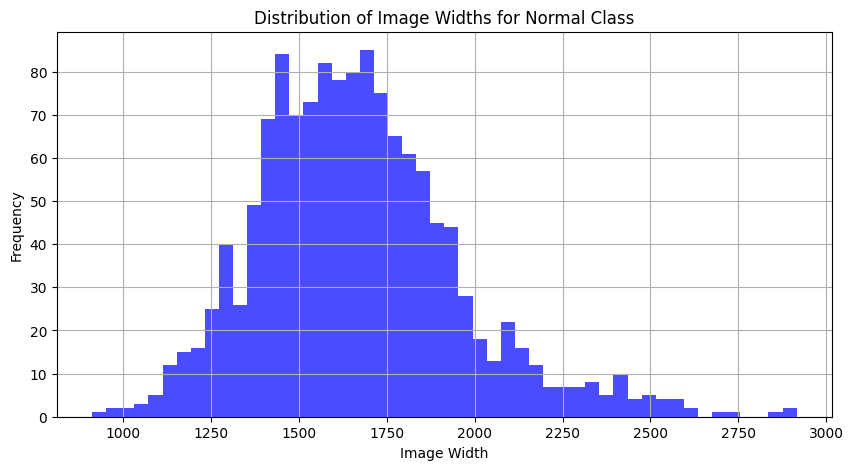

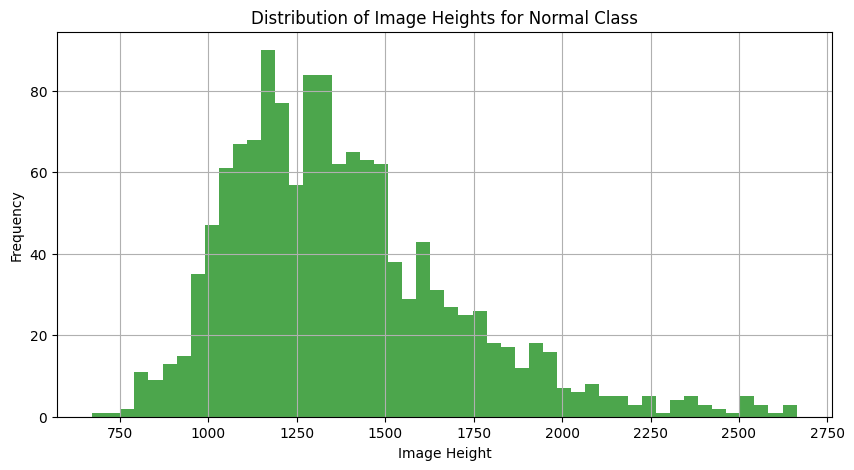

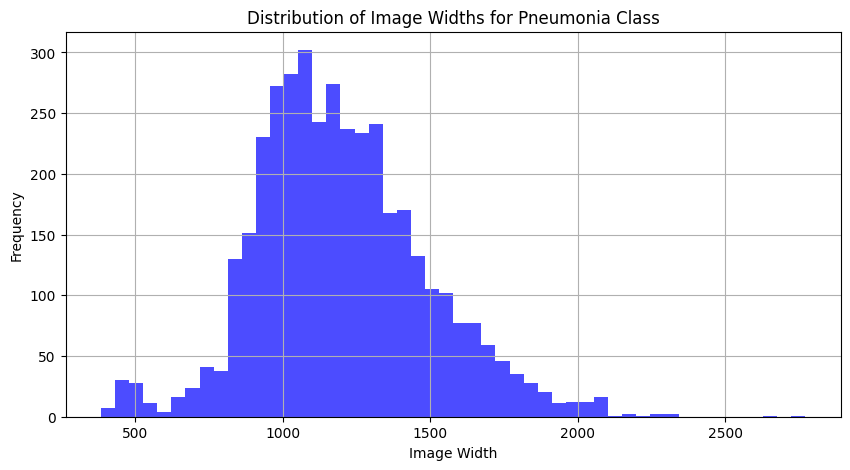

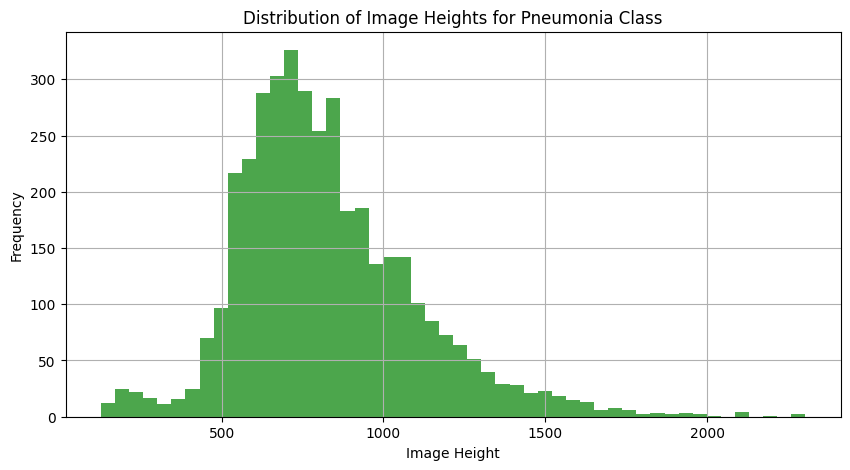

In [6]:
normal_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

def get_image_sizes(directory):
    image_sizes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):  # Adjust file extensions as needed
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                if image is not None:
                    height, width, _ = image.shape
                    image_sizes.append((width, height))
    return image_sizes

# Get image sizes for 'normal' class
normal_image_sizes = get_image_sizes(normal_dir)

# Extract width and height separately for 'normal' class
normal_widths, normal_heights = zip(*normal_image_sizes)

# Plot histogram for width of 'normal' class
plt.figure(figsize=(10, 5))
plt.hist(normal_widths, bins=50, color='blue', alpha=0.7)
plt.xlabel('Image Width')
plt.ylabel('Frequency')
plt.title('Distribution of Image Widths for Normal Class')
plt.grid(True)
plt.show()

# Plot histogram for height of 'normal' class
plt.figure(figsize=(10, 5))
plt.hist(normal_heights, bins=50, color='green', alpha=0.7)
plt.xlabel('Image Height')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights for Normal Class')
plt.grid(True)
plt.show()

# Get image sizes for 'pneumonia' class
pneumonia_image_sizes = get_image_sizes(pneumonia_dir)

# Extract width and height separately for 'pneumonia' class
pneumonia_widths, pneumonia_heights = zip(*pneumonia_image_sizes)

# Plot histogram for width of 'pneumonia' class
plt.figure(figsize=(10, 5))
plt.hist(pneumonia_widths, bins=50, color='blue', alpha=0.7)
plt.xlabel('Image Width')
plt.ylabel('Frequency')
plt.title('Distribution of Image Widths for Pneumonia Class')
plt.grid(True)
plt.show()

# Plot histogram for height of 'pneumonia' class
plt.figure(figsize=(10, 5))
plt.hist(pneumonia_heights, bins=50, color='green', alpha=0.7)
plt.xlabel('Image Height')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights for Pneumonia Class')
plt.grid(True)
plt.show()

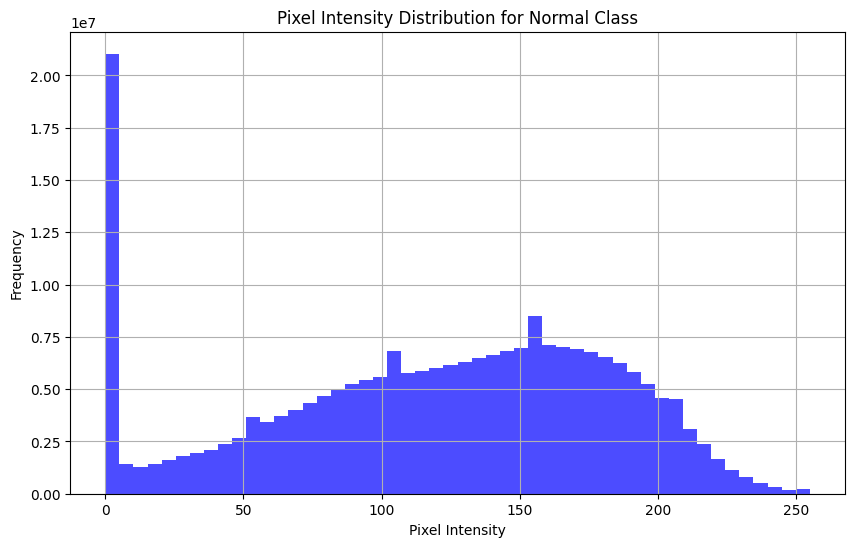

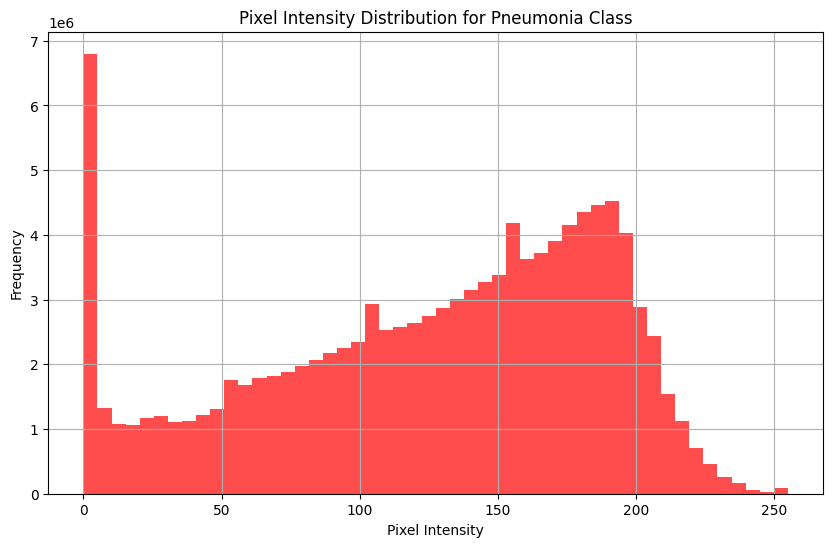

In [7]:
# Choose a sample of images for analysis
num_images_to_analyze = 100

# Function to load and analyze images from a directory
def analyze_images_from_directory(directory):
    pixel_intensity_values = []
    image_files = os.listdir(directory)
    for image_file in image_files[:num_images_to_analyze]:
        image_path = os.path.join(directory, image_file)
        try:
            image = cv2.imread(image_path)
            if image is not None:
                gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                flattened_image = gray_image.flatten()
                pixel_intensity_values.extend(flattened_image)
            else:
                print(f"Failed to load image: {image_path}")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
    return np.array(pixel_intensity_values)

# Analyze images for 'normal' class
normal_pixel_intensity_values = analyze_images_from_directory(normal_dir)

# Analyze images for 'pneumonia' class
pneumonia_pixel_intensity_values = analyze_images_from_directory(pneumonia_dir)

# Plot histogram of pixel intensity values for 'normal' class
plt.figure(figsize=(10, 6))
plt.hist(normal_pixel_intensity_values, bins=50, color='blue', alpha=0.7)
plt.title('Pixel Intensity Distribution for Normal Class')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram of pixel intensity values for 'pneumonia' class
plt.figure(figsize=(10, 6))
plt.hist(pneumonia_pixel_intensity_values, bins=50, color='red', alpha=0.7)
plt.title('Pixel Intensity Distribution for Pneumonia Class')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

T-statistic: -901.2626288746617
P-value: 0.0


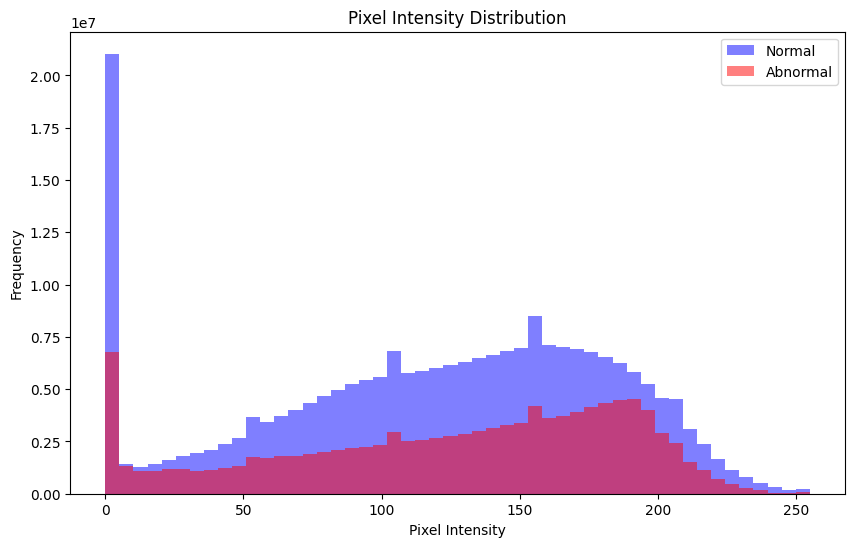

In [8]:
t_statistic, p_value = ttest_ind(normal_pixel_intensity_values.flatten(), pneumonia_pixel_intensity_values.flatten())

print("T-statistic:", t_statistic)
print("P-value:", p_value)

plt.figure(figsize=(10, 6))
plt.hist(normal_pixel_intensity_values.flatten(), bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(pneumonia_pixel_intensity_values.flatten(), bins=50, alpha=0.5, color='red', label='Abnormal')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.legend()
plt.show()


Found 5216 images belonging to 2 classes.


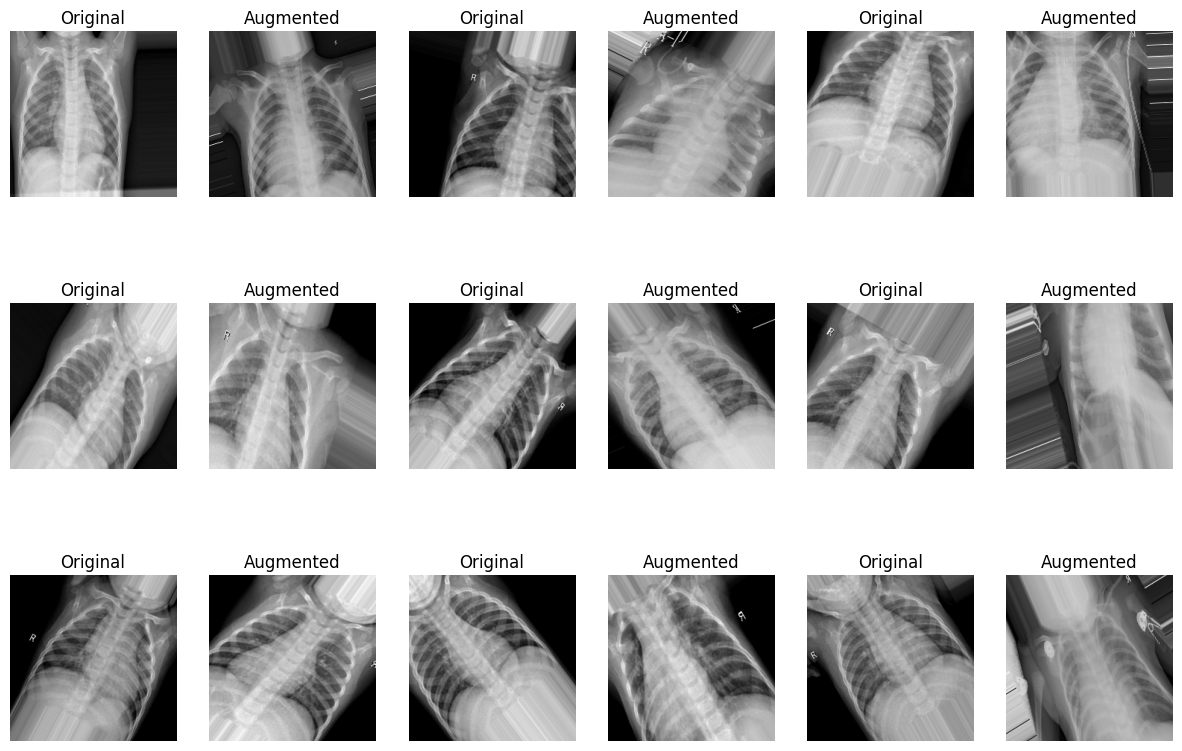

In [9]:
original_images, _ = next(train_augmentation_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=9,
    class_mode='binary',
    shuffle=False
))

augmented_images, _ = next(train_augmentation_generator)

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 6, 2*i + 1)
    plt.imshow(original_images[i])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(3, 6, 2*i + 2)
    plt.imshow(augmented_images[i])
    plt.title('Augmented')
    plt.axis('off')

plt.show()

In [10]:
# Load VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='/kaggle/input/vgg19w/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Flatten the output of the VGG19 base model
x = Flatten()(base_model.output)

# Add additional fully connected layers
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer with sigmoid activation for binary classification
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 26,447,425 (100.89 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_augmentation_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713141543.778799     121 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713141543.810184     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 779ms/step - accuracy: 0.7059 - loss: 2.6855 - val_accuracy: 0.5000 - val_loss: 0.8456
Epoch 2/20


W0000 00:00:1713141670.492473     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 662ms/step - accuracy: 0.7501 - loss: 0.5788 - val_accuracy: 0.5000 - val_loss: 0.9518
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 656ms/step - accuracy: 0.7433 - loss: 0.6137 - val_accuracy: 0.5000 - val_loss: 0.7772
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 647ms/step - accuracy: 0.7290 - loss: 0.5971 - val_accuracy: 0.5000 - val_loss: 0.7850
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 652ms/step - accuracy: 0.7475 - loss: 0.6134 - val_accuracy: 0.5000 - val_loss: 0.7553
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 656ms/step - accuracy: 0.7461 - loss: 0.5925 - val_accuracy: 0.5000 - val_loss: 0.8568
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 655ms/step - accuracy: 0.7273 - loss: 0.5997 - val_accuracy: 0.5000 - val_loss: 1.0747
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 652ms/step - accuracy: 0.7327 - loss: 0.6016 - val_accuracy: 0.5000 - val_loss: 0.8494
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 650ms/step - accuracy: 0.7490 - loss: 0.57

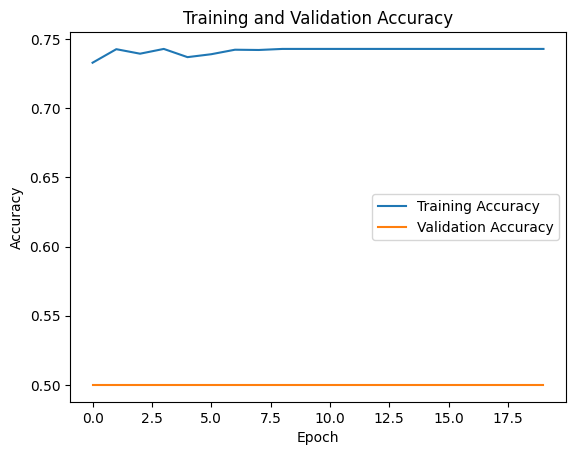

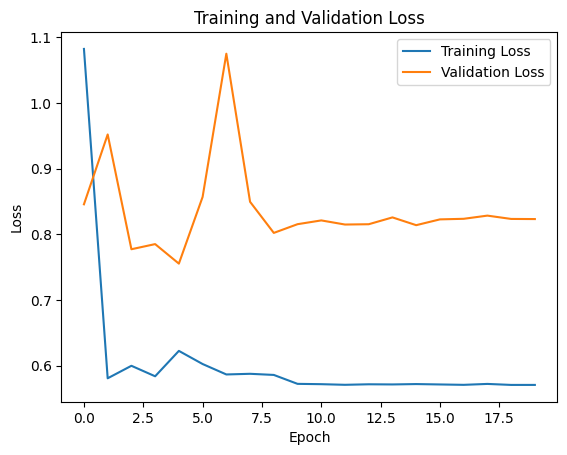

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
model.evaluate(test_generator)

 1/20 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6250 - loss: 0.6929

W0000 00:00:1713143779.323401     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - accuracy: 0.6175 - loss: 0.7007


[0.6928737759590149, 0.625]

In [14]:
# Transfer Learning VGG19
base_model = VGG19(weights='/kaggle/input/vgg19w/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

In [15]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
model1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(
    train_augmentation_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:38 8s/step - accuracy: 0.3438 - loss: 0.9615

W0000 00:00:1713143799.466290     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 629ms/step - accuracy: 0.7224 - loss: 19.4369 - val_accuracy: 0.7500 - val_loss: 0.5022
Epoch 2/20


W0000 00:00:1713143901.522929     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.7711 - loss: 0.5514 - val_accuracy: 0.6250 - val_loss: 0.9218
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 617ms/step - accuracy: 0.8053 - loss: 0.3975 - val_accuracy: 0.6250 - val_loss: 1.1477
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 623ms/step - accuracy: 0.8236 - loss: 0.3881 - val_accuracy: 0.6875 - val_loss: 0.7931
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 619ms/step - accuracy: 0.8475 - loss: 0.3580 - val_accuracy: 0.6875 - val_loss: 0.7396
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 623ms/step - accuracy: 0.8375 - loss: 0.3637 - val_accuracy: 0.6875 - val_loss: 0.8629
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 625ms/step - accuracy: 0.8477 - loss: 0.3490 - val_accuracy: 0.6875 - val_loss: 0.4511
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 622ms/step - accuracy: 0.8253 - loss: 0.3674 - val_accuracy: 0.6875 - val_loss: 0.8580
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 618ms/step - accuracy: 0.8651 - loss: 0.33

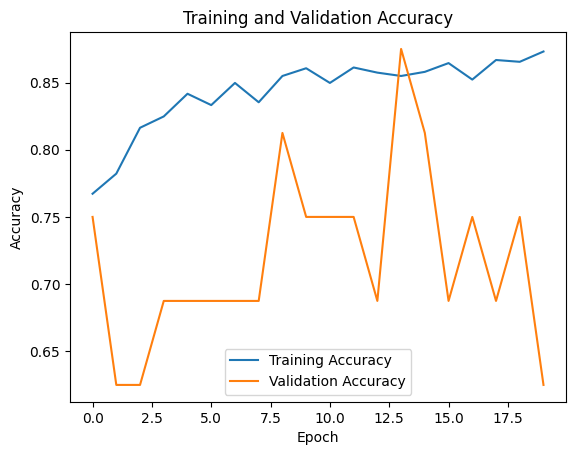

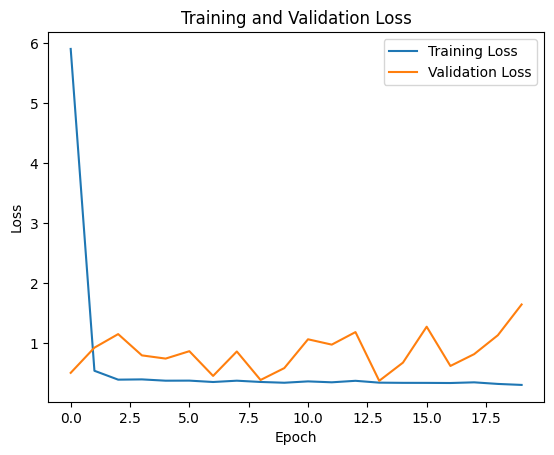

In [16]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
model1.evaluate(test_generator)

 1/20 ━━━━━━━━━━━━━━━━━━━━ 18s 959ms/step - accuracy: 0.6250 - loss: 1.5891

W0000 00:00:1713145923.395423     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 328ms/step - accuracy: 0.8257 - loss: 0.8411


[0.7975640892982483, 0.8397436141967773]

In [18]:
from tensorflow.keras.applications import ResNet50

# Load the ResNet50 model without the top (classification) layer
base_model = ResNet50(weights='/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Set the initial learning rate and define the learning rate schedule
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Freeze the layers of the base model so they are not trainable
for layer in base_model.layers:
    layer.trainable = False

# Flatten the output of the base model and add fully connected layers for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model2 = Model(inputs=base_model.input, outputs=predictions)


In [20]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(
    train_augmentation_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 135s 700ms/step - accuracy: 0.6556 - loss: 15.6709 - val_accuracy: 0.6875 - val_loss: 0.7558
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 623ms/step - accuracy: 0.7422 - loss: 1.0329 - val_accuracy: 0.5000 - val_loss: 2.1470
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 625ms/step - accuracy: 0.8209 - loss: 0.5014 - val_accuracy: 0.6250 - val_loss: 0.9427
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 626ms/step - accuracy: 0.8361 - loss: 0.3408 - val_accuracy: 0.6250 - val_loss: 0.8130
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 622ms/step - accuracy: 0.8441 - loss: 0.3320 - val_accuracy: 0.6250 - val_loss: 0.8089
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 617ms/step - accuracy: 0.8478 - loss: 0.3168 - val_accuracy: 0.6250 - val_loss: 0.7174
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 618ms/step - accuracy: 0.8439 - loss: 0.3276 - val_accuracy: 0.6250 - val_loss: 1.0877
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.8275 

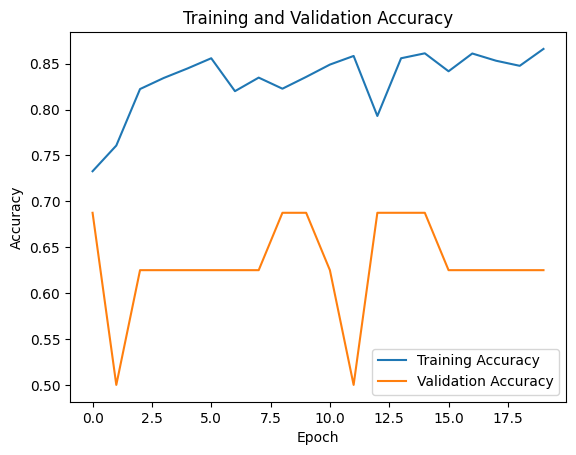

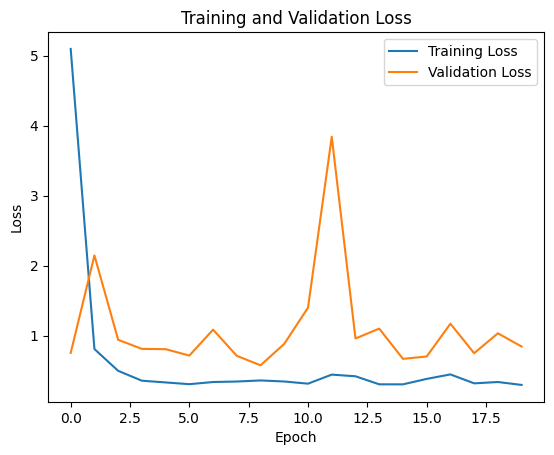

In [21]:
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:
model2.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - accuracy: 0.8411 - loss: 0.4072


[0.406139999628067, 0.8365384340286255]

In [23]:
model.save('basemodel.h5')

In [24]:
model1.save('VGG19.h5')

In [25]:
model2.save('resnet50.h5')

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

def create_model(optimizer='adam', dropout_rate=0.5, learning_rate=0.001):
    # Learning rate schedule function
    def lr_schedule(epoch):
        return learning_rate * tf.math.exp(-0.1 * epoch)

    # Load VGG19 model without top layers
    base_model = VGG19(weights='/kaggle/input/vgg19w/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the base model for fine-tuning
    for layer in base_model.layers:
        layer.trainable = False

    # Flatten the output of the base model
    x = Flatten()(base_model.output)

    # Add fully connected layers with Dropout
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    # Output layer with sigmoid activation for binary classification
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with placeholder optimizer and learning rate
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Define hyperparameters
optimizers = ['adam', 'rmsprop']
dropout_rates = [0.3, 0.5, 0.7]
learning_rates = [0.001, 0.0001, 0.00001]
epochs = 20
cv = 3  # Number of cross-validation folds (adjust if needed)

# Define data augmentation parameters for training data (adjust as needed)
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test data (optional preprocessing can be added here)
test_val_datagen = ImageDataGenerator()

# Define paths to your directories (replace with your actual paths)
train_dir = '/kaggle/input/pneumonia/Dl/train'
test_dir = '/kaggle/input/pneumonia/Dl/test'
validation_dir = '/kaggle/input/pneumonia/Dl/val'

# Set target image size (adjust as needed)
target_size = (224, 224)  # Example size for many pre-trained models

# Batch size (adjust based on GPU memory)
batch_size = 32

# Create training and validation data generators (modify if needed)
train_augmentation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'  # Change to 'categorical' if multiple classes
)

validation_generator = test_val_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Perform grid search
best_accuracy = 0
best_params = {}
for optimizer in optimizers:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            model = create_model(optimizer=optimizer, dropout_rate=dropout_rate, learning_rate=learning_rate)
            history = model.fit(
                train_augmentation_generator,
                steps_per_epoch=train_augmentation_generator.samples // batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=validation_generator.samples // batch_size,
                verbose=1
            )

            # Evaluate model on test data
            test_loss, test_accuracy = model.evaluate(
                test_generator,
                steps=test_generator.samples // batch_size,
                verbose=2
            )

            print(f"\nOptimizer: {optimizer}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}")
            print(f"Test Loss: {test_loss}")
            print(f"Test Accuracy: {test_accuracy}")

            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_params = {'optimizer': optimizer, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

# Summarize best results
print("\nBest Accuracy:", best_accuracy)
print("Best Parameters:", best_params)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 25:04 9s/step - accuracy: 0.3750 - loss: 8.8611

W0000 00:00:1713149516.138221     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 620ms/step - accuracy: 0.7805 - loss: 8.6442 - val_accuracy: 1.0000 - val_loss: 0.1963
Epoch 2/20


W0000 00:00:1713149616.748909     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1963
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 621ms/step - accuracy: 0.9030 - loss: 0.2490 - val_accuracy: 1.0000 - val_loss: 0.1108
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1108
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 624ms/step - accuracy: 0.8887 - loss: 0.2307 - val_accuracy: 0.9375 - val_loss: 0.2914
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.2914
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 621ms/step - accuracy: 0.8946 - loss: 0.2348 - val_accuracy: 1.0000 - val_loss: 0.0555
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0555
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 615ms/step - accuracy: 0.8

W0000 00:00:1713150574.152391     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 322ms/step - accuracy: 0.6250 - loss: 0.6619

Optimizer: adam, Dropout Rate: 0.3, Learning Rate: 0.001
Test Loss: 0.6619166135787964
Test Accuracy: 0.625
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:16 8s/step - accuracy: 0.6875 - loss: 7.7953

W0000 00:00:1713150589.671741     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 621ms/step - accuracy: 0.6879 - loss: 10.4926 - val_accuracy: 0.8125 - val_loss: 0.2682
Epoch 2/20


W0000 00:00:1713150690.413171     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.2682
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 624ms/step - accuracy: 0.8542 - loss: 0.2890 - val_accuracy: 0.9375 - val_loss: 0.1651
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1651
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 632ms/step - accuracy: 0.8782 - loss: 0.2367 - val_accuracy: 1.0000 - val_loss: 0.1057
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1057
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 622ms/step - accuracy: 0.8783 - loss: 0.2396 - val_accuracy: 1.0000 - val_loss: 0.1676
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1676
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 617ms/step - accuracy: 0.8

W0000 00:00:1713151648.817541     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 311ms/step - accuracy: 0.6234 - loss: 0.6633

Optimizer: adam, Dropout Rate: 0.3, Learning Rate: 0.0001
Test Loss: 0.6632774472236633
Test Accuracy: 0.6233552694320679
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 23:50 9s/step - accuracy: 0.3125 - loss: 12.7703

W0000 00:00:1713151664.669012     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 622ms/step - accuracy: 0.7903 - loss: 10.3087 - val_accuracy: 1.0000 - val_loss: 0.2489
Epoch 2/20


W0000 00:00:1713151765.495778     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.2489
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 619ms/step - accuracy: 0.9037 - loss: 0.2413 - val_accuracy: 0.9375 - val_loss: 0.1749
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1749
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.9291 - loss: 0.2090 - val_accuracy: 0.8750 - val_loss: 0.4106
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.4106
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 618ms/step - accuracy: 0.9258 - loss: 0.1958 - val_accuracy: 0.8750 - val_loss: 0.2496
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.2496
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 618ms/step - accuracy: 0.9

W0000 00:00:1713152724.659988     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 311ms/step - accuracy: 0.6217 - loss: 0.6527

Optimizer: adam, Dropout Rate: 0.3, Learning Rate: 1e-05
Test Loss: 0.6527055501937866
Test Accuracy: 0.6217105388641357
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 23:58 9s/step - accuracy: 0.7188 - loss: 2.2142

W0000 00:00:1713152740.772347     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 630ms/step - accuracy: 0.8132 - loss: 8.7369 - val_accuracy: 0.8750 - val_loss: 0.1893
Epoch 2/20


W0000 00:00:1713152842.993953     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.1893
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 622ms/step - accuracy: 0.8925 - loss: 0.2632 - val_accuracy: 0.8125 - val_loss: 0.2305
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.2305
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 626ms/step - accuracy: 0.9061 - loss: 0.2367 - val_accuracy: 0.9375 - val_loss: 0.2274
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.2274
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 630ms/step - accuracy: 0.9189 - loss: 0.2094 - val_accuracy: 0.8125 - val_loss: 0.2540
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.2540
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 628ms/step - accuracy: 0.9

W0000 00:00:1713153842.530042     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 320ms/step - accuracy: 0.6217 - loss: 0.6672

Optimizer: adam, Dropout Rate: 0.5, Learning Rate: 0.001
Test Loss: 0.667224645614624
Test Accuracy: 0.6217105388641357
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:34 8s/step - accuracy: 0.5938 - loss: 4.6380

W0000 00:00:1713153858.645910     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 641ms/step - accuracy: 0.8267 - loss: 6.2729 - val_accuracy: 0.8125 - val_loss: 0.2910
Epoch 2/20


W0000 00:00:1713153962.582170     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.2910
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 635ms/step - accuracy: 0.8958 - loss: 0.2575 - val_accuracy: 0.9375 - val_loss: 0.3006
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.3006
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 632ms/step - accuracy: 0.9025 - loss: 0.2508 - val_accuracy: 0.9375 - val_loss: 0.1701
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1701
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 632ms/step - accuracy: 0.9285 - loss: 0.2040 - val_accuracy: 0.8125 - val_loss: 0.3052
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.3052
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 636ms/step - accuracy: 0.9

W0000 00:00:1713154932.600776     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 321ms/step - accuracy: 0.6283 - loss: 0.6751

Optimizer: adam, Dropout Rate: 0.5, Learning Rate: 0.0001
Test Loss: 0.6750970482826233
Test Accuracy: 0.6282894611358643
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:43 8s/step - accuracy: 0.5000 - loss: 6.2385

W0000 00:00:1713154948.418906     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 636ms/step - accuracy: 0.8380 - loss: 5.4646 - val_accuracy: 1.0000 - val_loss: 0.0754
Epoch 2/20


W0000 00:00:1713155051.624589     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0754
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.9019 - loss: 0.2341 - val_accuracy: 1.0000 - val_loss: 0.1066
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1066
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 618ms/step - accuracy: 0.9291 - loss: 0.2091 - val_accuracy: 0.8125 - val_loss: 0.2074
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.2074
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 625ms/step - accuracy: 0.9179 - loss: 0.2163 - val_accuracy: 1.0000 - val_loss: 0.0568
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0568
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 618ms/step - accuracy: 0.9

W0000 00:00:1713156006.094296     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 305ms/step - accuracy: 0.6299 - loss: 0.6866

Optimizer: adam, Dropout Rate: 0.5, Learning Rate: 1e-05
Test Loss: 0.6865511536598206
Test Accuracy: 0.6299341917037964
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 23:57 9s/step - accuracy: 0.7188 - loss: 3.7230

W0000 00:00:1713156021.828021     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 619ms/step - accuracy: 0.8056 - loss: 7.8715 - val_accuracy: 0.7500 - val_loss: 0.3115
Epoch 2/20


W0000 00:00:1713156122.154954     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.3115
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 614ms/step - accuracy: 0.8609 - loss: 0.3205 - val_accuracy: 0.9375 - val_loss: 0.1692
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1692
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 618ms/step - accuracy: 0.8709 - loss: 0.3112 - val_accuracy: 1.0000 - val_loss: 0.1101
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1101
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 621ms/step - accuracy: 0.8714 - loss: 0.3106 - val_accuracy: 0.8750 - val_loss: 0.4213
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.4213
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 618ms/step - accuracy: 0.8

W0000 00:00:1713157073.040770     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 318ms/step - accuracy: 0.6266 - loss: 0.6535

Optimizer: adam, Dropout Rate: 0.7, Learning Rate: 0.001
Test Loss: 0.6535100936889648
Test Accuracy: 0.6266447305679321
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 23:28 9s/step - accuracy: 0.2500 - loss: 15.7838

W0000 00:00:1713157088.885501     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 627ms/step - accuracy: 0.7945 - loss: 7.8238 - val_accuracy: 0.8125 - val_loss: 0.3723
Epoch 2/20


W0000 00:00:1713157190.636031     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.3723
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 622ms/step - accuracy: 0.8649 - loss: 0.3301 - val_accuracy: 0.9375 - val_loss: 0.1605
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1605
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.8686 - loss: 0.2894 - val_accuracy: 0.9375 - val_loss: 0.1793
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1793
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 616ms/step - accuracy: 0.9007 - loss: 0.2407 - val_accuracy: 0.9375 - val_loss: 0.1978
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1978
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 618ms/step - accuracy: 0.8

W0000 00:00:1713158145.430611     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 309ms/step - accuracy: 0.6299 - loss: 0.6542

Optimizer: adam, Dropout Rate: 0.7, Learning Rate: 0.0001
Test Loss: 0.6541735529899597
Test Accuracy: 0.6299341917037964
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:51 8s/step - accuracy: 0.5312 - loss: 6.6847

W0000 00:00:1713158160.953675     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 623ms/step - accuracy: 0.7401 - loss: 8.6702 - val_accuracy: 0.5625 - val_loss: 0.4690
Epoch 2/20


W0000 00:00:1713158262.054183     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.4690
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 632ms/step - accuracy: 0.7736 - loss: 0.4246 - val_accuracy: 0.8750 - val_loss: 0.3670
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.3670
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 634ms/step - accuracy: 0.8322 - loss: 0.3762 - val_accuracy: 0.7500 - val_loss: 0.6874
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.6874
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 622ms/step - accuracy: 0.8520 - loss: 0.3479 - val_accuracy: 0.8125 - val_loss: 0.2958
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.2958
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 617ms/step - accuracy: 0.8

W0000 00:00:1713159254.514391     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 306ms/step - accuracy: 0.6234 - loss: 0.6521

Optimizer: adam, Dropout Rate: 0.7, Learning Rate: 1e-05
Test Loss: 0.6521126627922058
Test Accuracy: 0.6233552694320679
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 23:14 9s/step - accuracy: 0.4062 - loss: 5.9481

W0000 00:00:1713159270.281245     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 621ms/step - accuracy: 0.7931 - loss: 19.2342 - val_accuracy: 0.6250 - val_loss: 1.7047
Epoch 2/20


W0000 00:00:1713159370.954674     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 1.7047
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.8960 - loss: 0.3512 - val_accuracy: 0.8125 - val_loss: 0.4645
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.4645
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 615ms/step - accuracy: 0.9216 - loss: 0.2520 - val_accuracy: 0.6875 - val_loss: 0.9127
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.9127
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 627ms/step - accuracy: 0.9218 - loss: 0.2225 - val_accuracy: 1.0000 - val_loss: 0.0609
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0609
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 627ms/step - accuracy: 0.9

W0000 00:00:1713160331.194360     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 309ms/step - accuracy: 0.3783 - loss: 0.7205

Optimizer: rmsprop, Dropout Rate: 0.3, Learning Rate: 0.001
Test Loss: 0.7204981446266174
Test Accuracy: 0.37828946113586426
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 23:47 9s/step - accuracy: 0.4062 - loss: 8.6543

W0000 00:00:1713160347.536958     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 625ms/step - accuracy: 0.7920 - loss: 13.3082 - val_accuracy: 0.7500 - val_loss: 0.5197
Epoch 2/20


W0000 00:00:1713160448.843700     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5197
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 627ms/step - accuracy: 0.8942 - loss: 0.3539 - val_accuracy: 1.0000 - val_loss: 0.1776
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1776
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 623ms/step - accuracy: 0.9169 - loss: 0.2414 - val_accuracy: 0.9375 - val_loss: 0.1553
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1553
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.9264 - loss: 0.2237 - val_accuracy: 0.9375 - val_loss: 0.1240
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1240
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 627ms/step - accuracy: 0.9

W0000 00:00:1713161448.979478     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 311ms/step - accuracy: 0.3734 - loss: 0.7113

Optimizer: rmsprop, Dropout Rate: 0.3, Learning Rate: 0.0001
Test Loss: 0.7112610936164856
Test Accuracy: 0.37335526943206787
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 23:22 9s/step - accuracy: 0.4062 - loss: 4.1833

W0000 00:00:1713161464.904206     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 633ms/step - accuracy: 0.8169 - loss: 12.9791 - val_accuracy: 0.8125 - val_loss: 0.3589
Epoch 2/20


W0000 00:00:1713161567.616852     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.3589
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 629ms/step - accuracy: 0.8910 - loss: 0.3852 - val_accuracy: 0.5625 - val_loss: 1.9143
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 1.9143
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 630ms/step - accuracy: 0.9128 - loss: 0.3353 - val_accuracy: 1.0000 - val_loss: 0.0785
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0785
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 631ms/step - accuracy: 0.9260 - loss: 0.2488 - val_accuracy: 0.9375 - val_loss: 0.0713
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.0713
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 633ms/step - accuracy: 0.9

W0000 00:00:1713162568.440581     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 312ms/step - accuracy: 0.3865 - loss: 0.6960

Optimizer: rmsprop, Dropout Rate: 0.3, Learning Rate: 1e-05
Test Loss: 0.6959983706474304
Test Accuracy: 0.3865131437778473
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:43 8s/step - accuracy: 0.4688 - loss: 5.9050

W0000 00:00:1713162584.117159     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 625ms/step - accuracy: 0.8042 - loss: 16.6872 - val_accuracy: 0.5000 - val_loss: 1.5775
Epoch 2/20


W0000 00:00:1713162685.495801     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.5775
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.8813 - loss: 0.5162 - val_accuracy: 1.0000 - val_loss: 0.1381
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1381
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 617ms/step - accuracy: 0.8998 - loss: 0.3466 - val_accuracy: 0.7500 - val_loss: 0.5017
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5017
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 624ms/step - accuracy: 0.9062 - loss: 0.2799 - val_accuracy: 0.8125 - val_loss: 0.9575
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.9575
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 623ms/step - accuracy: 0.9

W0000 00:00:1713163645.173624     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 335ms/step - accuracy: 0.3734 - loss: 0.7091

Optimizer: rmsprop, Dropout Rate: 0.5, Learning Rate: 0.001
Test Loss: 0.7091285586357117
Test Accuracy: 0.37335526943206787
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:20 8s/step - accuracy: 0.5312 - loss: 4.5273

W0000 00:00:1713163661.172064     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 635ms/step - accuracy: 0.8050 - loss: 15.4342 - val_accuracy: 0.8750 - val_loss: 0.1909
Epoch 2/20


W0000 00:00:1713163764.136426     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.1909
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 622ms/step - accuracy: 0.8820 - loss: 0.3952 - val_accuracy: 0.8125 - val_loss: 0.3714
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.3714
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 617ms/step - accuracy: 0.9066 - loss: 0.3166 - val_accuracy: 0.9375 - val_loss: 0.1640
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1640
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 618ms/step - accuracy: 0.9192 - loss: 0.2662 - val_accuracy: 0.6875 - val_loss: 0.6174
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6875 - val_loss: 0.6174
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 620ms/step - accuracy: 0.9

W0000 00:00:1713164719.925910     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 340ms/step - accuracy: 0.3799 - loss: 0.6967

Optimizer: rmsprop, Dropout Rate: 0.5, Learning Rate: 0.0001
Test Loss: 0.696692943572998
Test Accuracy: 0.3799342215061188
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:31 8s/step - accuracy: 0.5312 - loss: 6.3880

W0000 00:00:1713164735.899162     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 623ms/step - accuracy: 0.8181 - loss: 13.9553 - val_accuracy: 0.9375 - val_loss: 0.1640
Epoch 2/20


W0000 00:00:1713164836.953995     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1640
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 629ms/step - accuracy: 0.8941 - loss: 0.4274 - val_accuracy: 0.9375 - val_loss: 0.2115
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.2115
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 625ms/step - accuracy: 0.9133 - loss: 0.3778 - val_accuracy: 0.9375 - val_loss: 0.1480
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1480
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 619ms/step - accuracy: 0.9203 - loss: 0.2708 - val_accuracy: 0.8750 - val_loss: 0.2328
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.2328
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 618ms/step - accuracy: 0.9

W0000 00:00:1713165829.745882     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 313ms/step - accuracy: 0.5609 - loss: 0.6905

Optimizer: rmsprop, Dropout Rate: 0.5, Learning Rate: 1e-05
Test Loss: 0.6904674768447876
Test Accuracy: 0.5608552694320679
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 23:26 9s/step - accuracy: 0.6562 - loss: 4.8267

W0000 00:00:1713165845.494513     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 624ms/step - accuracy: 0.8019 - loss: 11.4460 - val_accuracy: 0.8750 - val_loss: 0.4116
Epoch 2/20


W0000 00:00:1713165946.644991     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.4116
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 627ms/step - accuracy: 0.8632 - loss: 0.5961 - val_accuracy: 0.9375 - val_loss: 0.1808
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1808
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 622ms/step - accuracy: 0.8858 - loss: 0.4940 - val_accuracy: 0.8125 - val_loss: 0.2607
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.2607
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 627ms/step - accuracy: 0.9014 - loss: 0.3353 - val_accuracy: 1.0000 - val_loss: 0.0547
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0547
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 627ms/step - accuracy: 0.9

W0000 00:00:1713166906.627247     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 324ms/step - accuracy: 0.3717 - loss: 0.7257

Optimizer: rmsprop, Dropout Rate: 0.7, Learning Rate: 0.001
Test Loss: 0.7256685495376587
Test Accuracy: 0.37171053886413574
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 22:58 9s/step - accuracy: 0.6250 - loss: 6.0006

W0000 00:00:1713166922.517237     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 631ms/step - accuracy: 0.8014 - loss: 13.8524 - val_accuracy: 0.8750 - val_loss: 0.3549
Epoch 2/20


W0000 00:00:1713167024.889002     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.3549
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 625ms/step - accuracy: 0.8630 - loss: 0.7153 - val_accuracy: 0.8125 - val_loss: 0.3586
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.3586
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 632ms/step - accuracy: 0.8991 - loss: 0.4250 - val_accuracy: 1.0000 - val_loss: 0.0675
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0675
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 634ms/step - accuracy: 0.9007 - loss: 0.4276 - val_accuracy: 0.9375 - val_loss: 0.1685
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1685
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 627ms/step - accuracy: 0.9

W0000 00:00:1713167985.243622     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 315ms/step - accuracy: 0.3783 - loss: 0.7264

Optimizer: rmsprop, Dropout Rate: 0.7, Learning Rate: 0.0001
Test Loss: 0.7264119982719421
Test Accuracy: 0.37828946113586426
Epoch 1/20
  1/163 ━━━━━━━━━━━━━━━━━━━━ 21:55 8s/step - accuracy: 0.4375 - loss: 9.4915

W0000 00:00:1713168000.461124     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 630ms/step - accuracy: 0.7884 - loss: 11.9033 - val_accuracy: 0.8125 - val_loss: 1.0449
Epoch 2/20


W0000 00:00:1713168102.628550     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 1.0449
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 630ms/step - accuracy: 0.8586 - loss: 0.7122 - val_accuracy: 0.8125 - val_loss: 0.3901
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8125 - val_loss: 0.3901
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 632ms/step - accuracy: 0.8848 - loss: 0.4396 - val_accuracy: 0.8750 - val_loss: 0.2313
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.2313
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 638ms/step - accuracy: 0.8965 - loss: 0.3780 - val_accuracy: 0.9375 - val_loss: 0.1616
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9375 - val_loss: 0.1616
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 628ms/step - accuracy: 0.9

W0000 00:00:1713169072.044743     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 - 6s - 323ms/step - accuracy: 0.3734 - loss: 0.7948

Optimizer: rmsprop, Dropout Rate: 0.7, Learning Rate: 1e-05
Test Loss: 0.7947562336921692
Test Accuracy: 0.37335526943206787

Best Accuracy: 0.6299341917037964
Best Parameters: {'optimizer': 'adam', 'dropout_rate': 0.5, 'learning_rate': 1e-05}
